## Inventory Management

#### Author: Kemjika Ananaba

In this Project, we will review the economic order quantity (EOQ) model and its application when demand uncertainty is introduced. The periodic review model and continuous review model are also introduced using Monte Carlo simulation tools. We encourage you to create your own Jupytor Notebook and follow along. You can also download this Notebook together with any accompanying data from the [Notebooks and Data](https://github.com/Master-of-Business-Analytics/Notebooks_and_Data) GitHub Repository. Alternatively, if you do not have Python or Jupyter Notebook installed yet, you may experiment with a virtual Notebook by launching Binder or Syzygy below (learn more about these two tools in the [Resource](https://analytics-at-sauder.github.io/resource.html) tab). 

<a href="https://ubc.syzygy.ca/jupyter/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FAnalytics-at-Sauder%2FProject_04_Inventory_Management&urlpath=tree%2FProject_04_Inventory_Management%2Fp04_inventory_management.ipynb&branch=master" target="_blank" class="button">Launch Syzygy (UBC)</a>

<a href="https://pims.syzygy.ca/jupyter/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FAnalytics-at-Sauder%2FProject_04_Inventory_Management&urlpath=tree%2FProject_04_Inventory_Management%2Fp04_inventory_management.ipynb&branch=master" target="_blank" class="button">Launch Syzygy (Google)</a>

<a href="https://mybinder.org/v2/gh/Analytics-at-Sauder/Project_04_Inventory_Management/master?filepath=p04_inventory_management.ipynb" target="_blank" class="button">Launch Binder</a>


## Background
---
In the modern business environment, companies are requiring an increasing amount of effort to reduce operating costs and to improve customer satisfaction. Inventory can play a significant role in satisfying customer demand; therefore, inventory becomes an important asset for any organization. Thus, inventory should be managed effectively and efficiently in order to minimize total cost and to satisfy customer demand. In real life, inventory management faces several challenges, such as the tradeoff between minimizing total cost and maximizing service level; therefore, choosing the correct inventory policy is now essential to management.

## Economic Order Quantity (EOQ) Policy

For the age-old question "How much product should I order this time?", the simplest answer is the EOQ model. This policy assumes a constant demand and ignores the costs of lost sales. Instead, in the EOQ model, the tradeoff between the fixed ordering cost (or, if you are manufacturing the good, then the fixed setup cost) and the inventory carrying cost is evaluated to calculate the optimal order quantity.

<b> 1. EOQ = Qo = √ ((2 * Annual Demand * setup cost)/holding cost) </b>
<br>
<b> 2. Order cycle = √(Qo / Annual Demand) * Total working days in a year </b>
<br>
<b> 3. Total Cost = (Qo* holding cost / 2) + (Annual demand * Setup cost)/Qo </b>


As a quick background, the EOQ model is meant to answer the question “How much product should I order this time?” That is, when you order (or manufacture) a widget, should you order just one unit, a hundred units, a thousand units, or more? To answer that question, we need to understand the tradeoff between the fixed ordering cost (or, if you are manufacturing the good, then the fixed setup cost) and the inventory carrying cost. If there is a relatively high fixed cost, then we would want to order many units; however, if the inventory carrying cost is relatively high, we probably only want to order a few.

### EOQ  Model Example

The EOQ model is based on the application of the economic order quantity formula on historical data.

Manufacturer’s demand = 120,000units/year  

Manufacturer’s costs:

1. Fixed cost per shipment (ordering cost) = $500/shipment

2. Purchase cost = $1/unit

3. Cost of holding one unit in inventory for one year = $0.3

4. Selling Price = $7/unit

In [10]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
import operator

In [11]:
#Constant demand
d = 120000 #annual demand
S = 500 #ordering cost
h = 0.3 #holding cost
selling_price = 5
unit_cost = 1
optimal_quantity = math.sqrt((2*d*S)/h)
cycle_time = math.sqrt((2*S)/(h*d))
order_cycle = cycle_time *360 #Assuming total of 360 working days in a year


What is the buyer’s optimal order quantity?

In [12]:
optimal_quantity

20000.0

What is the ordering interval (in days)?

In [13]:
review_period_eoq = round(order_cycle,2)
review_period_eoq

60.0

### Simulation Model

The EOQ quantity and cycle time are applied in simulations that try to replicate a market with uncertain demand.
We assume that a review period of 60 days, an order quantity of 20,000 units, and a lead time of 0 days. The inventory status is recorded in the simulation.

<b> Creating a function to simulate daily demand</b>

In [14]:
# Creating a function that allocates the demand  if there is a purchase


def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)              #chose a random number between 1 and 0
    if random_num > probability:                      #if number is more than probability then there is no sale
        return 0
    else:
        return np.random.normal(mean, sd)
    #demand follows a log-normal distribution using mean and sd of the previous year's demand.

In [15]:
# Define Monte Carlo Simulation to replicate demand and inventory 
# M = capacity of the ware house
# review_period = Agreed time to place order (ie monthly = 30, every 10 days = 10)
# probability = Probability of a sale
# mean = Historical mean of sales
# sd = Historical sales standard deviation

            
def eoq_monte_carlo(M,review_period,probability,mean,sd):
    
    stock_out = 0
    inventory = M
    
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 360):
        day_demand = daily_demand(mean, sd, probability)
        day_demand = round(day_demand,0)
        
        #used to determine if there is a sale and what the demand would be
        data['daily_demand'].append(day_demand)
        if day % review_period == 0: 
            #check if the day to place order
            q = M # quantity to be ordered
            data['orders'].append(round(q,0))
            # update inventory when product has been received from manufacturer
            inventory += q
            
        inv_gap = inventory - day_demand
        
        if inv_gap >= 0: #check if inventory is enough to satisfy demand
            data['units_sold'].append(day_demand)
            inventory -= day_demand #reduce inventory by daily demand
        else:
            data['units_sold'].append(round(inventory,0))
            lost_sales = day_demand - inventory
            data['units_lost'].append(round(lost_sales,0))
            inventory = 0
            stock_out += 1

        data['inv_level'].append(round(inventory,0))

    return data

In [16]:
#function to total cost
# data = output from the monte carlo function

def calculate_cost(data,days,unit_cost,holding_cost,order_cost):

    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * (1 / days)
    cost = sum(data['orders']) * unit_cost

    cost =  cost + Co + Ch

    return cost

In [35]:
#function to calculate profit
def calculate_profit(data,days,unit_cost,holding_cost,order_cost,selling_p):

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * (1 / days)
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

### Application of EOQ Models on Constant Demand

This scenario assumes no uncertainty; in other words, this scenario assumes a constant demand and a purchase probability of 1. Therefore, the demand standard deviation is assumed to be 0, and the EOQ quantity and review period are used.

In [37]:
#applying EOQ model 
eoq_data = eoq_monte_carlo(M = 20000,review_period=60,probability=1,mean=333.3,sd=0)


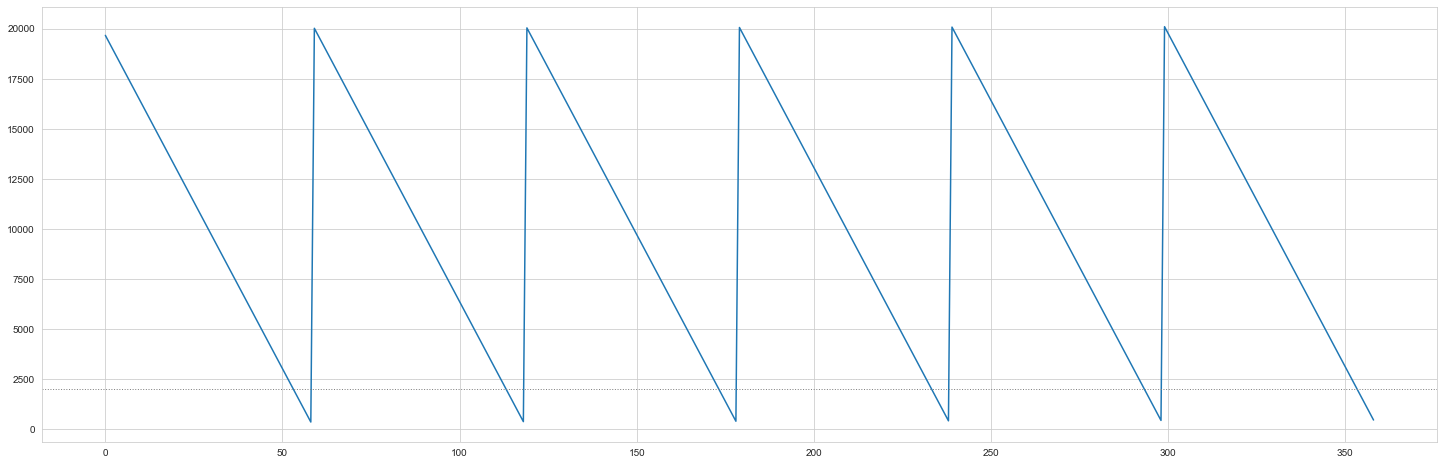

In [38]:
plt.figure(figsize=(25,8))
plt.plot(eoq_data['inv_level'])
plt.axhline(2000, linewidth=1, color="grey", linestyle=":")
plt.show()

In [39]:
cost = calculate_cost(eoq_data,days=360,unit_cost=1,holding_cost=0.3,order_cost=500)
cost

105551.28333333334

### Scenario 1: Applying the EOQ Model to an Uncertain Demand

The scenario below assumes there is uncertainty in demand for a product on any given day and uncertainty in the number of products demanded.

1. Probability of demand in a given day = 0.9

2. Mean daily demand = 333.3

3. Standard deviation of daily demand  = 20 

4. Lead time = 0


In [30]:
prob = 0.90 #probability of demand
mean_demand = 333.3
std_demand = 20
inventory = optimal_quantity #staring with EOQ

In [40]:
eoq_data2 = eoq_monte_carlo(M = 20000,review_period=60,probability=0.9,mean=333.3,sd=20)

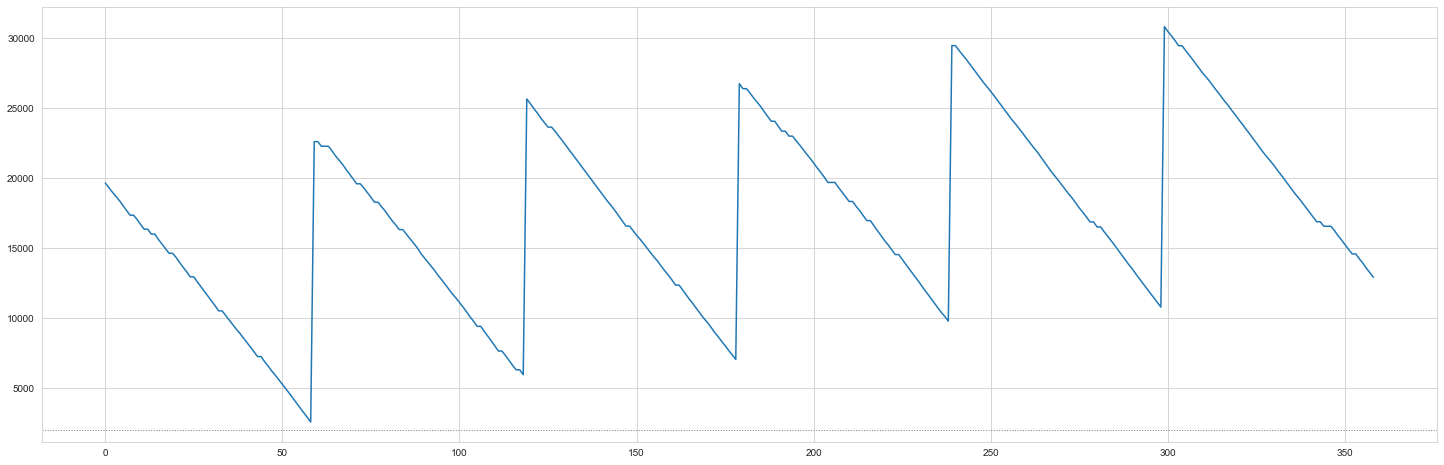

In [41]:
plt.figure(figsize=(25,8))
plt.plot(eoq_data2['inv_level'])
plt.axhline(2000, linewidth=1, color="grey", linestyle=":")
plt.show()


In [42]:
cost2 = calculate_cost(eoq_data2,days=360,unit_cost=1,holding_cost=0.3,order_cost=500)
cost2

107630.785

In [43]:
revenue2 = calculate_profit(eoq_data2,days=360,unit_cost=1,holding_cost=0.3,order_cost=500,selling_p=7)
revenue2

427814.215

The diagram above show that when the EOQ model is used to calculate the re-order quantity,  more and more inventory is held over time. The uncertainty in demand has caused an increase in costs due to an increase in the inventory cycle.

### Scenario 2:  Continuous Review Model

To combat the holding costs that can accumulate due to demand uncertainty, we can determine the reorder point by the inventory level. This policy is called the continuous review model.

In [44]:

def cc_monte_carlo(Capacity,reorder_point,probability,mean,sd):

    inventory = Capacity

    order_placed = False
    order_time = 0
    stock_out = 0
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    
    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        day_demand = round(day_demand,0)
        
        #used to determine if there is a sale and what the demand would be
        data['daily_demand'].append(day_demand)
        if inventory <= reorder_point :
            # Time to place an order
            
            inventory += Capacity
            data['orders'].append(round(Capacity,0))
            #increase inventory with order quantity
            
        
        inv_gap = inventory - day_demand
        
        if inv_gap >= 0: #check if inventory is enough to satisfy demand
            data['units_sold'].append(day_demand)
            inventory -= day_demand #reduce inventory by daily demand
        else:
            data['units_sold'].append(round(inventory,0))
            lost_sales = day_demand - inventory
            data['units_lost'].append(round(lost_sales,0))
            inventory = 0
            stock_out += 1

        data['inv_level'].append(round(inventory,0))

    return data

In [45]:
cc_data=cc_monte_carlo(Capacity=20000,reorder_point=0,probability=1,mean=333.3,sd=20)

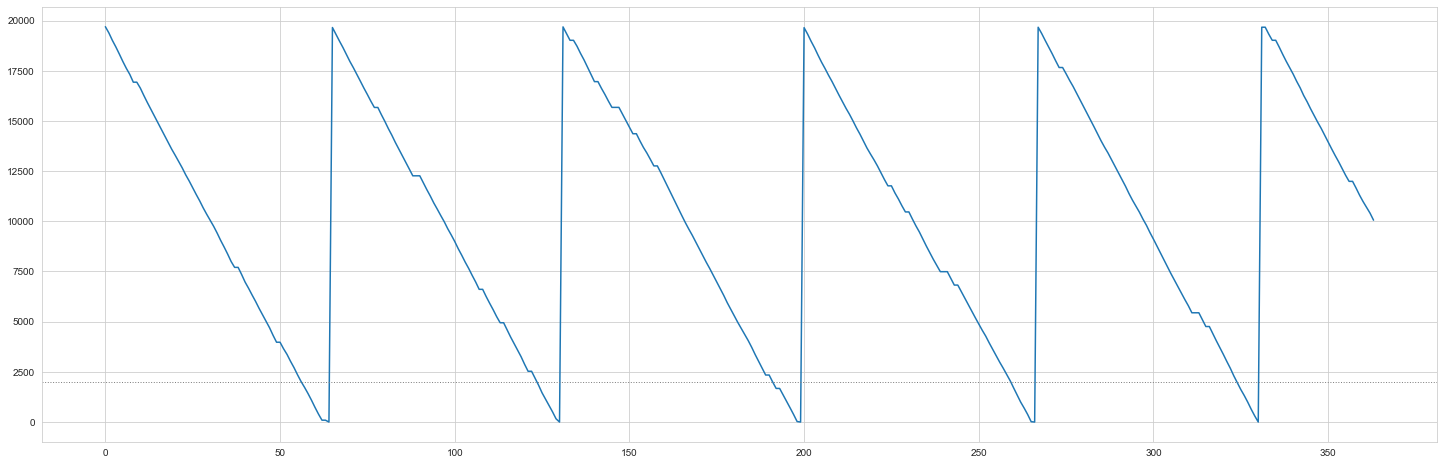

In [168]:
plt.figure(figsize=(25,8))
plt.plot(cc_data['inv_level'])
plt.axhline(2000, linewidth=1, color="grey", linestyle=":")
plt.show()

In [169]:
cost3 = calculate_cost(cc_data,days=360,unit_cost=1,holding_cost=0.3,order_cost=500)
cost3

105592.545

In [175]:
revenue3 = calculate_profit(cc_data,days=360,unit_cost=1,holding_cost=0.3,order_cost=500,selling_p=7)
revenue3

1665835.64935

The costs using this model are slightly lower than those of the EOQ model, and consequently, the expected profits from the continuous review model are higher than that of the EOQ model.

### Scenario 3: Periodic Review Model

Another policy to consider is the periodic review policy. Here, the reorder point is the same as the EOQ model; however, the quantity ordered varies according to the maximum order point. The order up-to quantity, M, is 20,000. 

The difference between the EOQ model and the periodic review model is that the periodic review compares the current inventory status to the capacity of the warehouse at the review period. The difference between the current inventory status and the ware house capacity is used as the reorder quantity.

In [161]:
# Define Monte Carlo Simulation to imitate a periodic review model 

            
def pr_monte_carlo(M,review_period,probability,mean,sd):
    inventory = M
    q = 0
    stock_out = 0
    order_placed = False
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        day_demand = round(day_demand,0)
        
        #used to determine if there is a sale and what the demand would be
        data['daily_demand'].append(day_demand)
        if day % review_period == 0: 
            #check if the day to place order
            q = M - inventory # quantity to be ordered
            data['orders'].append(round(q,0))
            # update inventory when product has been received from manufacturer
            inventory += q
            
        inv_gap = inventory - day_demand
        
        if inv_gap >= 0: #check if inventory is enough to satisfy demand
            data['units_sold'].append(day_demand)
            inventory -= day_demand #reduce inventory by daily demand
        else:
            data['units_sold'].append(round(inventory,0))
            lost_sales = day_demand - inventory
            data['units_lost'].append(round(lost_sales,0))
            inventory = 0
            stock_out += 1

        data['inv_level'].append(round(inventory,0))

    return data

In [162]:
pr_data= pr_monte_carlo(M = 20000,review_period=60,probability=0.9,mean=333.3,sd=20)

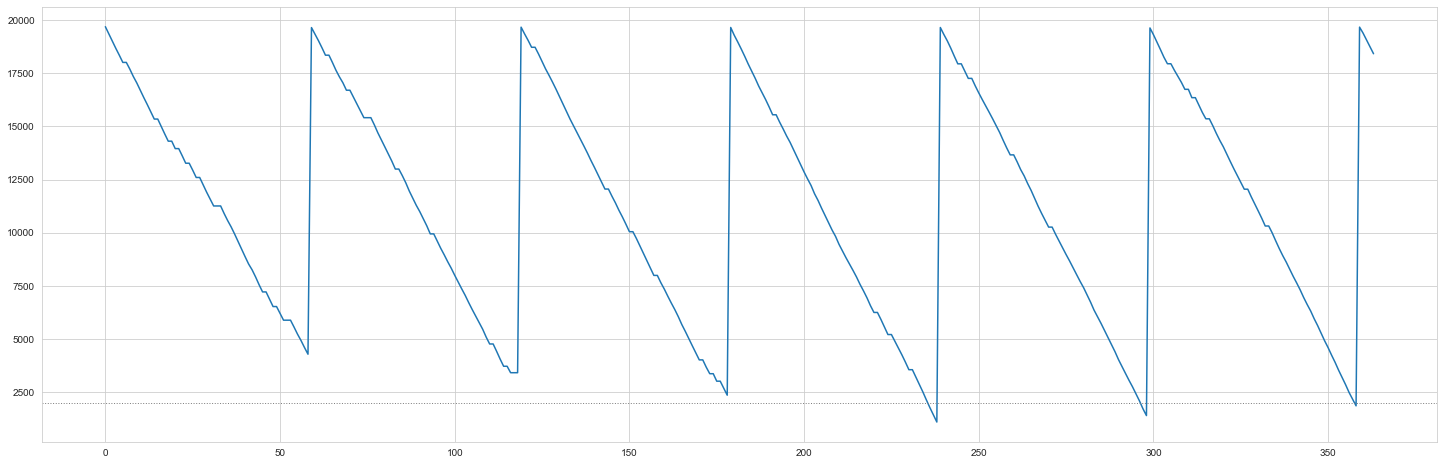

In [163]:
plt.figure(figsize=(25,8))
plt.plot(pr_data['inv_level'])
plt.axhline(2000, linewidth=1, color="grey", linestyle=":")
plt.show()

In [164]:
cost4 = calculate_cost(pr_data,days=360,unit_cost=1,holding_cost=0.3,order_cost=500)
cost4

112017.3925

In [176]:
revenue4 = calculate_profit(pr_data,days=360,unit_cost=1,holding_cost=0.3,order_cost=500,selling_p=7)
revenue4

1615675.1662750002

In [180]:
summ_table =  pd.DataFrame({'EOQ': [cost2, revenue2],'Continous Review':[cost3,revenue3],'Periodic Review':[cost4,revenue4]})
idx = ['Costs', 'Revenue']
summ_table = summ_table.set_index(pd.Index(idx))
summ_table

,EOQ,Continous Review,Periodic Review
Costs,1.073597e+05,1.055925e+05,1.120174e+05
Revenue,1.628700e+06,1.665836e+06,1.615675e+06


## Final Conclusion

From the tables above, we can see that the continuous review policy (scenario 2) outperforms the EOQ model (scenario 1) and the periodic review policy (scenario 3) in terms of the expected profits for each product and proportion of lost orders.

Both the continuous and periodic review policies have their advantages. The periodic review policy has a fixed review period, which allows companies to better forecast the orders they made over some time. On the other hand, the continuous review policy keeps the order size constant and offers flexibility with regards to the times at which to place the order. 

The expected profits are dependent on different costs (holding costs, ordering costs or manufacturing costs, etc.) that are different for every product and organization. The right inventory management model depends on the impact of these cost and the demand distribution of the product.


## References
[1] Anderson, Sweeney, Williams, Camm, Cochran, Fry, Ohlmann. An Introduction to Management Science: Quantitative approaches to Decision Making. 14th Edition, 2015. Cengage Learning. pp. 457–478.

[2] Nagpurkar, M. (2020, April 2). Inventory Management using Python. Retrieved June 3, 2020, from https://towardsdatascience.com/inventory-management-using-python-17cb7ddf9314